<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

# Select Task

In [2]:
task = 9

# Prepare data

In [3]:
import numpy as np
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164']]
                             .rename({'VAR169': f'SSRD {i}',
                                      'VAR175': f'STRD {i}',
                                      'VAR178': f'TSR {i}', 
                                      'VAR228': f'TP {i}',
                                      'VAR164': f'TCC {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

<AxesSubplot:xlabel='TIMESTAMP'>

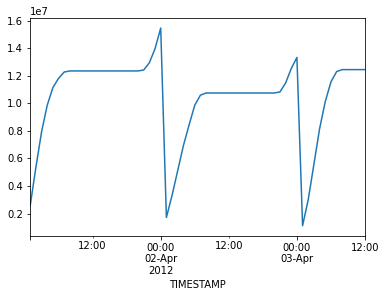

In [5]:
predictor_data['SSRD 1'][:60].plot()

In [6]:
# decumulate data
from itertools import product

for name, zoneid in product(['SSRD', 'STRD', 'TSR'], range(1, 4)):
    subtract = predictor_data[f'{name} {zoneid}'].shift(1)
    subtract.iloc[::24] = 0

    predictor_data[f'{name} {zoneid}'] -= subtract

<AxesSubplot:xlabel='TIMESTAMP'>

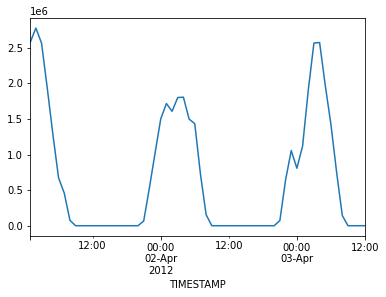

In [7]:
predictor_data['SSRD 1'].iloc[:60].plot()

In [8]:
for i in range(1, 4):
    predictor_data[f'SSRD {i}'] /= predictor_data[f'SSRD {i}'].max()
    predictor_data[f'STRD {i}'] /= predictor_data[f'STRD {i}'].max()
    predictor_data[f'TSR {i}'] /= predictor_data[f'TSR {i}'].max()
    predictor_data[f'TP {i}'] /= predictor_data[f'TP {i}'].max()

In [9]:
predictor_zones = []
train_data_zones = []

for zoneid in range(1, 4):
    predictor = predictor_data[[f'SSRD {zoneid}', f'STRD {zoneid}', f'TSR {zoneid}', f'TP {zoneid}', f'TCC {zoneid}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {zoneid}']]
    train_data_zones.append(train_data_zone)

In [10]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [12]:
from tqdm import tqdm

yq_output_zones = []

for x_input, y_output in tqdm(zip(x_input_zones, y_output_zones)):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

3it [01:31, 30.66s/it]


In [13]:
yq_output_zones[0].head()

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.000127,0.070676,0.161032,0.197321,0.218144,0.219649,0.246029,0.260869,0.263796,0.265071,...,0.745006,0.745889,0.748695,0.752129,0.752415,0.754282,0.757897,0.762869,0.765105,0.799210
2012-04-01 02:00:00,0.126721,0.163046,0.180944,0.183013,0.197692,0.201595,0.230351,0.259628,0.271146,0.274359,...,0.778231,0.781225,0.785926,0.787113,0.788963,0.792814,0.812687,0.825374,0.842110,0.867338
2012-04-01 03:00:00,0.059335,0.074941,0.078365,0.086092,0.089455,0.098533,0.099401,0.100779,0.115306,0.142577,...,0.707423,0.713683,0.743151,0.744319,0.758596,0.765949,0.808995,0.826135,0.867688,0.902115
2012-04-01 04:00:00,0.025881,0.026840,0.027792,0.029790,0.031760,0.034450,0.037000,0.042487,0.044115,0.049308,...,0.491532,0.504894,0.579231,0.612263,0.622396,0.657026,0.659392,0.671538,0.740003,0.743474
2012-04-01 05:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.258474,0.278747,0.292531,0.329688,0.446844,0.452734,0.456187,0.493401,0.578062,0.659457


# Train the linear regression model (ANN6)

In [14]:
predictor_zones[0].head()

,SSRD 1,STRD 1,TSR 1,TP 1,TCC 1
TIMESTAMP,,,,,
2012-04-01 01:00:00,0.633853,0.749657,0.673847,0.000000,0.244601
2012-04-01 02:00:00,0.683136,0.775649,0.727011,0.000000,0.457138
2012-04-01 03:00:00,0.630869,0.769635,0.703986,0.028372,0.771429
2012-04-01 04:00:00,0.476707,0.773120,0.563346,0.052930,0.965866
2012-04-01 05:00:00,0.315368,0.830914,0.417683,0.070487,0.944669


In [15]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index(drop=True).rename(columns={
        f'SSRD {zoneid}': 'SSRD',
        f'STRD {zoneid}': 'STRD',
        f'TSR {zoneid}': 'TSR', 
        f'TP {zoneid}': 'TP',
        f'TCC {zoneid}': 'TCC'})
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,SSRD,STRD,TSR,TP,TCC
0,0.633853,0.749657,0.673847,0.000000,0.244601
1,0.683136,0.775649,0.727011,0.000000,0.457138
2,0.630869,0.769635,0.703986,0.028372,0.771429
3,0.476707,0.773120,0.563346,0.052930,0.965866
4,0.315368,0.830914,0.417683,0.070487,0.944669
...,...,...,...,...,...
15355,0.053123,0.687016,0.077673,0.001617,0.163549
15356,0.234686,0.720799,0.276505,0.001687,0.114380
15357,0.443417,0.705758,0.479557,0.001687,0.360260
15358,0.603365,0.740379,0.641488,0.001687,0.851685


## Prepare data for regression model

In [16]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)\
            .rename(columns={'SSRD': f't-{h1 - i - 1}: SSRD',
                             'STRD': f't-{h1 - i - 1}: STRD',
                             'TSR': f't-{h1 - i - 1}: TSR',
                             'TP': f't-{h1 - i - 1}: TP',
                             'TCC': f't-{h1 - i - 1}: TCC'})
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x_zones.append(x)

x_zones[0]

,t-0: SSRD,t-0: STRD,t-0: TSR,t-0: TP,t-0: TCC,t-1: SSRD,t-1: STRD,t-1: TSR,t-1: TP,t-1: TCC,...,t-22: SSRD,t-22: STRD,t-22: TSR,t-22: TP,t-22: TCC,t-23: SSRD,t-23: STRD,t-23: TSR,t-23: TP,t-23: TCC
23,0.368656,0.854196,0.442339,0.143899,0.932465,0.250320,0.788924,0.314938,0.143687,0.953293,...,0.683136,0.775649,0.727011,0.000000,0.457138,0.633853,0.749657,0.673847,0.000000,0.244601
24,0.422394,0.818798,0.513562,0.004051,0.830276,0.368656,0.854196,0.442339,0.143899,0.932465,...,0.630869,0.769635,0.703986,0.028372,0.771429,0.683136,0.775649,0.727011,0.000000,0.457138
25,0.395441,0.839785,0.504277,0.005573,0.685303,0.422394,0.818798,0.513562,0.004051,0.830276,...,0.476707,0.773120,0.563346,0.052930,0.965866,0.630869,0.769635,0.703986,0.028372,0.771429
26,0.443019,0.860700,0.536485,0.006023,0.768799,0.395441,0.839785,0.504277,0.005573,0.685303,...,0.315368,0.830914,0.417683,0.070487,0.944669,0.476707,0.773120,0.563346,0.052930,0.965866
27,0.444153,0.840864,0.529245,0.006281,0.538910,0.443019,0.860700,0.536485,0.006023,0.768799,...,0.165400,0.812934,0.257348,0.083795,0.641353,0.315368,0.830914,0.417683,0.070487,0.944669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,0.053123,0.687016,0.077673,0.001617,0.163549,0.000000,0.757794,-0.000004,0.001617,0.957397,...,0.434632,0.728449,0.470086,0.000000,0.130951,0.207524,0.731501,0.252322,0.000000,0.408813
15356,0.234686,0.720799,0.276505,0.001687,0.114380,0.053123,0.687016,0.077673,0.001617,0.163549,...,0.625884,0.703882,0.654123,0.000000,0.000000,0.434632,0.728449,0.470086,0.000000,0.130951
15357,0.443417,0.705758,0.479557,0.001687,0.360260,0.234686,0.720799,0.276505,0.001687,0.114380,...,0.803501,0.708161,0.815432,0.000000,0.000000,0.625884,0.703882,0.654123,0.000000,0.000000
15358,0.603365,0.740379,0.641488,0.001687,0.851685,0.443417,0.705758,0.479557,0.001687,0.360260,...,0.920247,0.710644,0.924654,0.000000,0.000000,0.803501,0.708161,0.815432,0.000000,0.000000


## Feature selection

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=50).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, x.columns[support]]
    x_new_zones.append(x_new)

(14616, 120)
(14616,)
[  0   1   2   5   7  10  12  15  17  30  32  35  37  40  41  42  45  46
  47  50  51  52  55  56  57  60  61  62  65  67  70  72  75  77  79  80
  82  84  95  97 100 102 105 107 110 112 113 115 117 118]
(14616, 120)
(14616,)
[  0   1   2   5   6   7  10  12  15  17  30  32  35  37  40  42  45  47
  50  52  55  57  60  62  65  67  70  72  75  77  79  80  82  84  89  95
  97  98 100 102 103 105 107 108 110 112 113 115 117 118]
(14616, 120)
(14616,)
[  0   2   5   7  10  12  15  17  30  32  35  37  40  42  45  47  50  52
  55  57  60  62  65  67  70  72  75  77  80  82  84  89  93  95  97  98
 100 102 103 105 107 108 110 112 113 114 115 117 118 119]


# Training

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

from tqdm import tqdm

ensemble_size = 1

prediction_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    prediction = pd.DataFrame()

    for p in tqdm(range(1, 100)):
        y_train = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
        x_train = x_new[:-gefcom14_metadata['prediction_length']]
        x_predict = x_new[-gefcom14_metadata['prediction_length']:]

        model = BaggingRegressor(base_estimator=MLPRegressor(hidden_layer_sizes=(20,10,)),
                                 n_estimators=ensemble_size)

        trained = model.fit(x_train, y_train)
        prediction.insert(p-1, str(p/100), trained.predict(x_predict))
    prediction_zones.append(prediction)

100%|██████████| 99/99 [01:03<00:00,  1.55it/s]


In [19]:
prediction_zones[0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.402301,0.371866,0.421844,0.483087,0.445949,0.606827,0.506908,0.524052,0.547601,0.559624,...,0.856643,0.859418,0.889030,0.860527,0.843663,0.879950,0.879541,0.849268,0.868978,0.931143
1,0.340778,0.390917,0.408492,0.492149,0.503342,0.502256,0.497439,0.530130,0.570957,0.582626,...,0.860536,0.814117,0.853070,0.827943,0.823961,0.815240,0.890774,0.864348,0.820952,0.885998
2,0.344791,0.380206,0.427281,0.459666,0.451394,0.472577,0.506306,0.476682,0.536764,0.550406,...,0.848133,0.844850,0.849046,0.851896,0.796156,0.845870,0.836716,0.855137,0.848948,0.841508
3,0.280084,0.323479,0.355105,0.390507,0.375820,0.461316,0.397282,0.400456,0.469418,0.476997,...,0.834015,0.840891,0.825368,0.842819,0.805340,0.831265,0.800415,0.846059,0.842728,0.773890
4,0.204856,0.249629,0.297149,0.313156,0.320853,0.326058,0.373055,0.345035,0.384003,0.378774,...,0.769480,0.807507,0.819092,0.782259,0.824518,0.805349,0.786733,0.822179,0.841524,0.826744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,0.008190,0.000299,0.009657,0.029369,0.009710,-0.021661,-0.000593,-0.008344,0.002382,-0.003198,...,0.045797,0.085587,0.019727,0.052068,0.011993,0.050605,0.088651,0.152504,0.127581,0.126974
740,0.033841,0.056479,0.038574,0.066977,0.036218,0.024767,0.026574,0.050880,0.039901,0.045222,...,0.427002,0.513379,0.507050,0.443919,0.499452,0.534309,0.571887,0.527103,0.594674,0.570269
741,0.093218,0.114652,0.053842,0.125479,0.106699,0.106502,0.145506,0.109065,0.176502,0.109205,...,0.683872,0.718451,0.721571,0.739807,0.754707,0.749661,0.774055,0.770731,0.794301,0.895336
742,0.119206,0.176157,0.156815,0.196780,0.215077,0.233155,0.243987,0.245312,0.287244,0.259511,...,0.758175,0.790078,0.810891,0.808275,0.812816,0.773033,0.816385,0.822889,0.845118,0.764479


# Postprocessing: Remove quantile crossing

In [20]:
predictions_no_quantile_crossing_zones = []

sorting = True

for i, prediction in enumerate(prediction_zones):
    if sorting:
        # eliminate quantile crossing by sorting
        prediction = np.maximum(prediction, 0)
        prediction.values.sort()
    else:
        # eliminate quantile crossing by taking the maximum
        prediction['0.01'] = np.maximum(prediction['0.01'], 0)
        for p in range(2, 100):
            prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])

    zoneid = i+1
    prediction.insert(0, 'ZONEID', zoneid)
    predictions_no_quantile_crossing_zones.append(prediction)

In [21]:
prediction = pd.concat(predictions_no_quantile_crossing_zones)

## Plot predictions

In [22]:
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,1,0.371866,0.402301,0.421844,0.445949,0.483087,0.506908,0.515359,0.524052,0.547601,...,0.888478,0.889030,0.890907,0.892315,0.901101,0.913231,0.922064,0.931143,0.949630,0.961462
1,1,0.340778,0.390917,0.408492,0.492149,0.497439,0.502256,0.503342,0.515359,0.524569,...,0.845472,0.845633,0.848746,0.853070,0.860536,0.863560,0.864348,0.869675,0.885998,0.890774
2,1,0.344791,0.380206,0.427281,0.451394,0.459666,0.472577,0.476682,0.506306,0.515359,...,0.836716,0.841508,0.844850,0.845870,0.848133,0.848948,0.849046,0.851896,0.855137,0.866224
3,1,0.280084,0.323479,0.355105,0.375820,0.390507,0.397282,0.400456,0.457185,0.461316,...,0.808159,0.817102,0.818130,0.825368,0.831265,0.834015,0.840891,0.842728,0.842819,0.846059
4,1,0.204856,0.249629,0.297149,0.313156,0.320853,0.326058,0.345035,0.373055,0.374198,...,0.796818,0.805349,0.807507,0.808284,0.813121,0.819092,0.822179,0.824518,0.826744,0.841524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070232,0.075054,0.075573,0.079146,0.092721,0.097786,0.102303,0.117798,0.122405,0.184153
740,3,0.037644,0.043139,0.045485,0.049320,0.053650,0.054408,0.055125,0.060574,0.067147,...,0.475478,0.491273,0.498800,0.530861,0.544017,0.562151,0.569580,0.575285,0.628817,0.661043
741,3,0.070682,0.104867,0.151508,0.161029,0.181075,0.182653,0.200064,0.208748,0.209284,...,0.718301,0.725715,0.726865,0.735818,0.767334,0.767938,0.768553,0.785277,0.785339,0.788915
742,3,0.208121,0.213975,0.245300,0.249954,0.256299,0.257343,0.258651,0.259820,0.261615,...,0.778444,0.785093,0.788544,0.790554,0.791705,0.801246,0.803726,0.805143,0.834982,0.841024


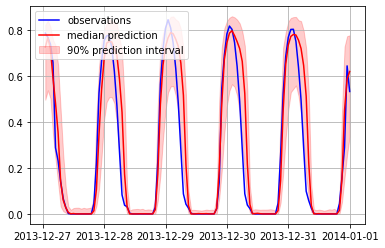

In [24]:
import matplotlib.pyplot as plt

def plot_prob_forecasts(target, forecast, output_file=None):
    prediction_length = 5 * 24
    prediction_intervals = (50, 90)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    plt.plot(target[-prediction_length:], 'b')
    for p in prediction_intervals:
        if p != 50:
            lower = forecast[str(p/100)]
            upper = forecast[str(round(1-p/100, 2))]

            plt.fill_between(
                target[-prediction_length:].index, lower[-prediction_length:], upper[-prediction_length:], alpha=0.2, color="r",
                label="Pred. interval")
        else:
            median = forecast[str(p/100)]
            plt.plot(target[-prediction_length:].index, median[-prediction_length:], 'r')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    if output_file is not None:
        plt.savefig(output_file)
    plt.show()

target = train_data_zones[0]
forecast = prediction[prediction['ZONEID'] == 1]
plot_prob_forecasts(target, forecast, output_file=f'nnqf_plot_{task}.pdf')

## Save predictions to csv

In [25]:
!mkdir -p results

In [26]:
prediction.to_csv(f'results/prediction_nnqf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,...,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,1,0.371866,0.402301,0.421844,0.445949,0.483087,0.506908,0.515359,0.524052,0.547601,...,0.888478,0.889030,0.890907,0.892315,0.901101,0.913231,0.922064,0.931143,0.949630,0.961462
1,1,0.340778,0.390917,0.408492,0.492149,0.497439,0.502256,0.503342,0.515359,0.524569,...,0.845472,0.845633,0.848746,0.853070,0.860536,0.863560,0.864348,0.869675,0.885998,0.890774
2,1,0.344791,0.380206,0.427281,0.451394,0.459666,0.472577,0.476682,0.506306,0.515359,...,0.836716,0.841508,0.844850,0.845870,0.848133,0.848948,0.849046,0.851896,0.855137,0.866224
3,1,0.280084,0.323479,0.355105,0.375820,0.390507,0.397282,0.400456,0.457185,0.461316,...,0.808159,0.817102,0.818130,0.825368,0.831265,0.834015,0.840891,0.842728,0.842819,0.846059
4,1,0.204856,0.249629,0.297149,0.313156,0.320853,0.326058,0.345035,0.373055,0.374198,...,0.796818,0.805349,0.807507,0.808284,0.813121,0.819092,0.822179,0.824518,0.826744,0.841524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070232,0.075054,0.075573,0.079146,0.092721,0.097786,0.102303,0.117798,0.122405,0.184153
740,3,0.037644,0.043139,0.045485,0.049320,0.053650,0.054408,0.055125,0.060574,0.067147,...,0.475478,0.491273,0.498800,0.530861,0.544017,0.562151,0.569580,0.575285,0.628817,0.661043
741,3,0.070682,0.104867,0.151508,0.161029,0.181075,0.182653,0.200064,0.208748,0.209284,...,0.718301,0.725715,0.726865,0.735818,0.767334,0.767938,0.768553,0.785277,0.785339,0.788915
742,3,0.208121,0.213975,0.245300,0.249954,0.256299,0.257343,0.258651,0.259820,0.261615,...,0.778444,0.785093,0.788544,0.790554,0.791705,0.801246,0.803726,0.805143,0.834982,0.841024


# Plotting the quantile prediction for the first entries

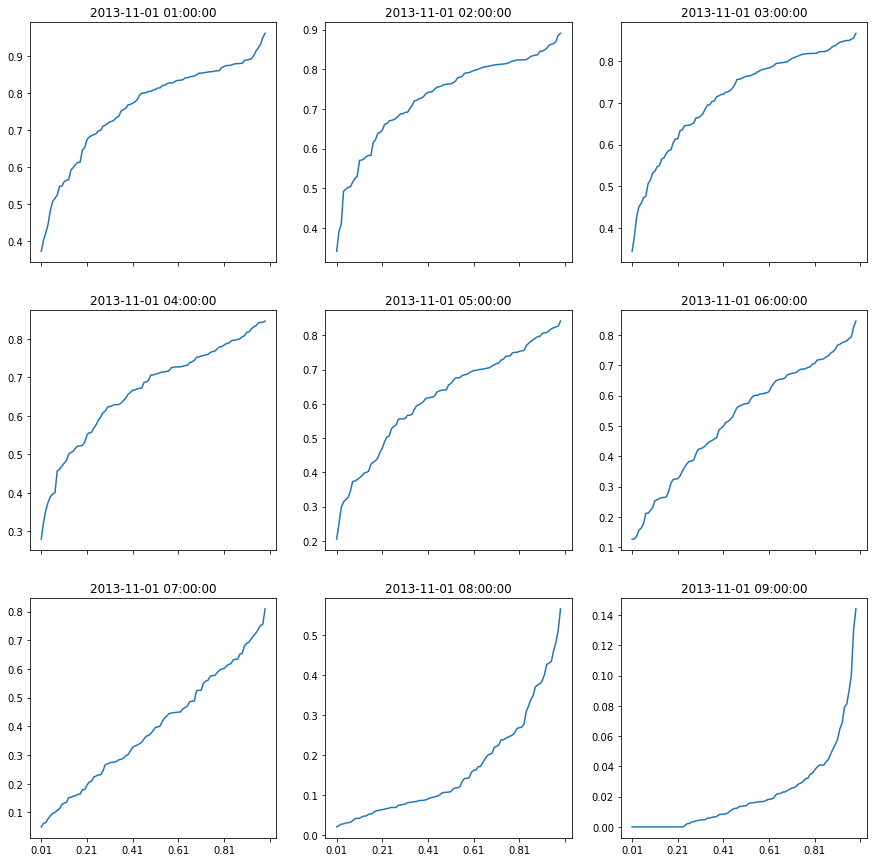

In [27]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [28]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [29]:
test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 9 with NNQF: 0.02463
